# Project #3 - Predictive Analytics on Tapsell's Advertisement Dataset

#### This data is mainly provided for the task of click prediction in Mediaad digital advertising platform. Mediaad shows native ads on website pages. Each webpage has some places that serve the advertisements which is called widgets. Each widget can show single or multiple ads. The goal of this task is to predict whether a user will click on a specific ad or not.

#### Click on <a href="https://drive.google.com/file/d/1tVYbSaG0JdxTLLPSAESnBNvj_RIxKg5B/view?usp=sharing">this link</a> to download the dataset and <a href="https://github.com/tapsellbrain/mediaad-dataset/wiki/Dataset-Description">this link</a> to get more information about the dataset. 

## ➡️&nbsp; Loading The Dataset

**Load `event.csv`, `user_page_view.csv`, `creative.csv`, `click_train.csv`, and `creative_image.csv`. Check for any missing, duplicated, or unrelated values and handle them properly.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import re

In [2]:
event_df = pd.read_csv('./csv_files_2/event.csv')
user_page_view_df = pd.read_csv('./csv_files_2/user_page_view.csv')
creative_df = pd.read_csv('./csv_files_2/creative.csv')
click_train_df = pd.read_csv('./csv_files_2/click_train.csv')
creative_image_df = pd.read_csv('./csv_files_2/creative_image.csv')


In [3]:
print('number of null for event is ', np.sum(event_df.isnull().sum()))
print('number of null for user page view is ', np.sum(user_page_view_df.isnull().sum()))
print('number of null for creative is ', np.sum(creative_df.isnull().sum()))
print('number of null for click train is ', np.sum(click_train_df.isnull().sum()))
print('number of null for creative image is ', np.sum(creative_image_df.isnull().sum()))

number of null for event is  0
number of null for user page view is  0
number of null for creative is  0
number of null for click train is  0
number of null for creative image is  0


In [42]:
event_df.duplicated().sum()

0

In [43]:
print(user_page_view_df.duplicated().sum())
user_page_view_df.drop_duplicates(inplace=True)
user_page_view_df.reset_index(inplace=True, drop=True)

646270

## ➡️&nbsp; EDA

**Find the top five advertisers with the most number of ads. How many advertisement campaigns does each one have?**

In [4]:
top_five_advertisers = creative_df.advertiserId.value_counts().index[:5].tolist()
top_five_advertisers

[8414, 6578, 2167, 7903, 6973]

In [5]:
[ np.unique(creative_df[creative_df['advertiserId'] == i]['campaignId']) for i in top_five_advertisers]

[array([2055, 5606, 5918, 6155, 7285, 8343]),
 array([ 693, 1474, 2552, 4227, 6344, 6850, 7270, 7426]),
 array([ 316, 2031, 2664, 4355, 5043, 6280, 6380, 7861, 8078, 8398, 8804,
        8824, 8885, 9029]),
 array([1001, 3997, 4042, 4044, 4155, 4611, 5564, 6775, 6782, 7691, 8265,
        8964]),
 array([ 784, 2837, 3674, 3771, 3930, 4416, 4566, 4956, 4981, 6070, 7143,
        8449])]

**Which webpage (`docID`) received the biggest number of clicks? Which ads were displayed on that page?**

In [6]:
user_page_view_df['docId'].value_counts()

2285483    3594743
8116       3009369
197         984285
1098340     855729
8           663735
            ...   
7722313          1
4080305          1
7722330          1
9092660          1
4240042          1
Name: docId, Length: 1265521, dtype: int64

In [7]:
event_df['docId'].value_counts()

8116       20023
2285483    17862
205         9588
555         4915
163         4427
           ...  
7530909        1
8529925        1
726341         1
8529910        1
6074354        1
Name: docId, Length: 188417, dtype: int64

**Using `event.csv` and `click_train.csv` tables, find the top 100 users who have clicked on ads more that any other person. What type of device they were using?**

In [8]:
# unique_displayId , counts= np.unique(click_train_df['displayId'], return_counts=True)
# # unique_displayId
# number_of_clicked_unique_displayId = []
# number_of_clicked_unique_displayId.append([(i,np.sum(click_train_df[click_train_df['displayId'] == i ]['clicked'])) for i in unique_displayId])
# number_of_clicked_unique_displayId

## ➡️ Coversion Rate

**For each `creativeId` (a unique ID associated with each ad/creative) calculate how many times on average they were clicked on. We refer to this rate as "conversion rate". Draw a histogram of the conversion rates for all creativeId's.**

In [9]:
unique_creativeId , counts= np.unique(click_train_df['creativeId'], return_counts=True)
number_of_clicked_unique_creativeId = []
number_of_clicked_unique_creativeId.append([(i,click_train_df[click_train_df['creativeId'] == i ]['clicked'].sum()/click_train_df['clicked'].sum()) for i in unique_creativeId])

In [10]:
len(unique_creativeId)

2616

In [11]:
number_of_clicked_unique_creativeId_df = pd.DataFrame(number_of_clicked_unique_creativeId[0], columns=['creative_id', 'conversion_rate'])
number_of_clicked_unique_creativeId_df

,creative_id,conversion_rate
0,6,0.008550
1,7,0.000751
2,8,0.003032
3,11,0.000512
4,13,0.000458
...,...,...
2611,7177,0.000025
2612,7178,0.000105
2613,7179,0.000038
2614,7181,0.000632


<AxesSubplot:xlabel='creative_id', ylabel='conversion_rate'>

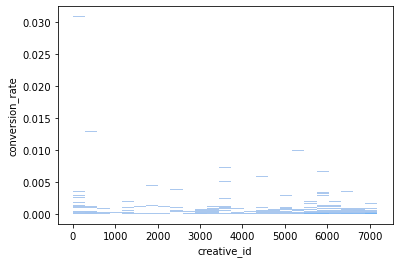

In [12]:
sns.histplot(data=number_of_clicked_unique_creativeId_df, x='creative_id', y='conversion_rate')

**For ads displayed to users with different device type (`device` in `event.csv`) calculated coversion rate? Do you observe any noticable difference between these groups?**

In [13]:
# unique_userId , counts= np.unique(event_df['userId'], return_counts=True)

# unique_userId_list = []
# event_df[event_df['userId'] == 44 ]['device'] == 0
# len(unique_userId)


In [14]:
# a = []
# a.append([(0 ,sum(event_df[event_df['userId'] == j ]['device'] == 0)) for j in unique_userId])


**For ads displayed to users with different operating systems (`OS` in `event.csv`) calculated coversion rate? Do you observe any noticable difference between these groups?**

## ➡️ Coversion Rate Prediction

**Using `creative_image.csv` we would like to predict a creativeId's conversion rate given its image features. Create a feature matrix and a target vector. Each row in feature matrix corresponds to a sample in the dataset and each column is associated with a certain feature that is extracted from ad images.**

**Use a linear regression model to predict conversion rate given image features for each creativeId. Evaluate your model's performance using 5-fold cross-validation. Does adding polynomial features boost the performance? Use mean-squared-error as your evaluation metric.**

In [15]:
merge_of_ci_and_nocucd = creative_image_df.merge(number_of_clicked_unique_creativeId_df, left_on='creativeId', right_on='creative_id')
merge_of_ci_and_nocucd.drop(columns=['creative_id'], inplace=True)

merge_of_ci_and_nocucd

,creativeId,imageFeatures,conversion_rate
0,7182,"[0.17772938311100006, 0.6273877620697021, 0.55...",0.000873
1,7181,"[0.27603843808174133, 0.1960456222295761, 0.34...",0.000632
2,7179,"[0.2053901106119156, 0.0146206459030509, 0.0, ...",0.000038
3,7178,"[1.1388229131698608, 0.041852112859487534, 0.0...",0.000105
4,7177,"[0.974502444267273, 0.08183272927999496, 0.077...",0.000025
...,...,...,...
2611,13,"[0.14816689491271973, 0.04346756637096405, 1.3...",0.000458
2612,11,"[0.04297146946191788, 0.01642996445298195, 0.0...",0.000512
2613,8,"[0.15623298287391663, 0.00098716514185071, 0.0...",0.003032
2614,7,"[0.10627733916044235, 0.08754178136587143, 3.3...",0.000751


In [16]:
def transform_tonparr (x):
    return np.fromstring(x[1:9694], dtype=np.float32, sep=',')

In [ ]:
data_x = np.asarray(merge_of_ci_and_nocucd['imageFeatures'].apply(transform_tonparr))

In [18]:
index_list = []
for i in range(len(data_x)):
    if data_x[i].shape != (512,):
       index_list.append(i)
       
len(index_list)

449

In [19]:
merge_of_ci_and_nocucd.drop(index_list, inplace=True)
merge_of_ci_and_nocucd.reset_index(drop=True)

,creativeId,imageFeatures,conversion_rate
0,7182,"[0.17772938311100006, 0.6273877620697021, 0.55...",0.000873
1,7179,"[0.2053901106119156, 0.0146206459030509, 0.0, ...",0.000038
2,7178,"[1.1388229131698608, 0.041852112859487534, 0.0...",0.000105
3,7177,"[0.974502444267273, 0.08183272927999496, 0.077...",0.000025
4,7176,"[1.1482311487197876, 0.04249534755945206, 4.01...",0.000001
...,...,...,...
2162,17,"[0.0, 0.03668755665421486, 0.0, 0.008968604728...",0.030849
2163,11,"[0.04297146946191788, 0.01642996445298195, 0.0...",0.000512
2164,8,"[0.15623298287391663, 0.00098716514185071, 0.0...",0.003032
2165,7,"[0.10627733916044235, 0.08754178136587143, 3.3...",0.000751


In [ ]:
data_x = merge_of_ci_and_nocucd['imageFeatures'].apply(transform_tonparr)
data_y = np.asarray(merge_of_ci_and_nocucd['conversion_rate'])

In [21]:
data_x.reset_index(inplace=True, drop=True)
data_x_array = np.zeros((2167, 512))

for i in range(data_x_array.shape[0]):
    for j in range(data_x_array.shape[1]):
        data_x_array[i][j] = data_x[i][j]
data_x_array = data_x_array[:,:512]

In [22]:
data_y_df = pd.DataFrame({'Conversion_rate': data_y})
data_x_df = pd.DataFrame(data_x_array)
data_x_df


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.177729,0.627388,0.554075,0.158078,0.000000,0.564610,0.012419,0.289449,0.384751,0.028059,...,0.291895,0.000000,1.638153,0.178412,1.086942,0.109618,3.026506,0.304689,0.195961,0.810012
1,0.205390,0.014621,0.000000,0.006130,0.136217,0.007052,0.132421,0.000000,0.000000,0.454989,...,0.063945,0.139984,0.935905,0.000000,0.025835,0.086115,0.043867,0.287675,0.443077,0.018351
2,1.138823,0.041852,0.000385,0.035156,0.377168,0.123878,1.203102,0.024890,0.674865,0.520424,...,0.048359,0.143126,0.506860,1.717038,0.500506,0.601653,0.292321,0.000000,0.811480,0.247876
3,0.974502,0.081833,0.077752,0.101681,0.560510,0.043694,1.515122,0.075695,0.951731,0.551668,...,0.106524,0.061194,0.234053,2.097951,0.974011,1.424949,0.100139,0.000000,0.537639,0.229753
4,1.148231,0.042495,0.000040,0.035591,0.374510,0.117952,1.176178,0.029085,0.661570,0.513891,...,0.046108,0.141073,0.511836,1.704248,0.510590,0.610252,0.296499,0.000000,0.787640,0.260506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,0.000000,0.036688,0.000000,0.008969,0.000000,0.016015,0.107154,0.082726,0.230364,0.538150,...,0.355940,0.095126,0.080091,0.000000,0.077815,0.023795,0.037816,0.068410,0.059110,0.046348
2163,0.042971,0.016430,0.070029,0.000000,0.562984,0.223415,1.144221,0.630494,0.123705,0.154114,...,0.058076,0.099905,1.024207,0.749125,0.017977,1.022663,2.738049,0.022185,0.135937,0.710172
2164,0.156233,0.000987,0.014774,0.207742,0.038036,0.011584,0.449074,0.066243,0.148653,0.325433,...,0.000000,0.000000,0.000000,0.441291,0.193914,0.639011,0.046036,0.000000,0.061070,0.125147
2165,0.106277,0.087542,3.344223,0.645454,1.301556,0.121954,0.000000,0.000000,0.000000,0.049404,...,0.938022,0.733772,0.000000,1.211627,0.486232,0.000000,0.118570,0.079808,0.159126,0.012901


In [23]:
X_train, X_test, y_train, y_test = train_test_split(data_x_df, data_y_df, test_size=0.33, random_state=42)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1451, 512), (716, 512), (1451, 1), (716, 1))

In [25]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, scoring='r2', cv=5)
scores

array([-1.30525449, -0.76216456, -5.15683309, -2.78754728, -0.57452432])

In [26]:
lr.fit(X=X_train,y=y_train)

LinearRegression()

In [27]:
predictions = lr.predict(X_test)
predictions[0]

array([0.00084001])

In [28]:
mean_squared_error(y_test, predictions)

2.5859324457599465e-06

In [29]:
mean_absolute_error(y_test, predictions)

0.001090276157887872

In [30]:
lr.score(X_train,y_train)

0.4711762032238874

In [31]:
r2_score(y_true=y_test,y_pred=predictions)

-1.7876444878268112

**Find a subset of image features that contain the most amount of information about the target values. You may use correlation matrix for this purpose.**

In [32]:
corrM = data_x_df.corr()
corrM

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,1.000000,-0.041962,-0.167773,-0.156091,0.146929,0.006149,0.171778,-0.029683,0.192774,0.081956,...,-0.102248,-0.044358,0.104259,0.103855,0.493052,0.209943,-0.059952,-0.127424,0.215875,0.139543
1,-0.041962,1.000000,0.038932,-0.054015,-0.003891,0.172429,-0.045641,0.169393,0.041669,-0.012099,...,0.060993,0.101085,0.141441,0.015631,-0.077055,0.088219,0.010177,0.055734,0.138642,0.019276
2,-0.167773,0.038932,1.000000,0.231551,0.165345,-0.017470,-0.083602,-0.055390,-0.148802,-0.048301,...,0.369918,0.036954,-0.083189,0.096472,-0.058922,-0.157938,0.157972,0.131814,-0.013594,-0.151906
3,-0.156091,-0.054015,0.231551,1.000000,-0.010342,0.004429,-0.113943,-0.095054,-0.091192,-0.106132,...,0.119003,-0.015348,-0.163250,-0.087638,-0.011266,-0.184888,0.019459,0.077970,-0.114146,-0.175242
4,0.146929,-0.003891,0.165345,-0.010342,1.000000,0.095751,0.134065,-0.046160,0.038451,-0.035593,...,0.023446,-0.009384,0.054863,0.121655,0.134321,0.024873,0.065909,-0.019639,0.149446,-0.033986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.209943,0.088219,-0.157938,-0.184888,0.024873,-0.084395,0.164122,0.021536,0.235400,0.046090,...,-0.014093,-0.082125,0.049341,0.134433,0.160276,1.000000,0.010780,-0.076136,0.109266,0.370253
508,-0.059952,0.010177,0.157972,0.019459,0.065909,0.062321,-0.097159,0.163895,-0.066216,-0.028172,...,0.266281,-0.110859,0.068646,0.088073,0.049408,0.010780,1.000000,0.010842,-0.045290,0.063417
509,-0.127424,0.055734,0.131814,0.077970,-0.019639,0.067280,-0.147069,0.153386,0.090195,-0.080556,...,0.108426,-0.021223,0.055457,-0.109866,-0.101230,-0.076136,0.010842,1.000000,-0.095732,-0.009980
510,0.215875,0.138642,-0.013594,-0.114146,0.149446,0.096049,0.129001,-0.030145,0.080972,0.149513,...,-0.007166,0.151161,0.183780,0.084349,0.106010,0.109266,-0.045290,-0.095732,1.000000,0.101451


**Apply PCA on image features. Plot a diagram to depict variance accross each calculated principle componenet. Choose a few principle components along which image features has to larget variance.**

**Construct a linear regression model and fit the model on the transformed image features you calculated previously. Evaluate your model's performance using 5-fold cross-validation. Does transforming data using PCA help increase model's performance?**

In [33]:
pca = PCA(n_components=0.80)
X_train_pca = pca.fit_transform(data_x_df)
X_train, X_test, y_train, y_test = train_test_split(X_train_pca, data_y_df, test_size=0.33, random_state=42)

lr.fit(X=X_train_pca,y=data_y_df)

LinearRegression()

In [34]:
principalDf = pd.DataFrame(data = X_train_pca)
principalDf.describe()

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
count,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03,...,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03,2.167000e+03
mean,7.234125e-17,1.340260e-16,1.086143e-16,8.545695e-17,-2.390028e-16,1.160944e-16,-1.977601e-17,-1.798285e-17,-2.218397e-17,4.995235e-17,...,-1.905874e-17,-4.299745e-17,-1.081020e-17,2.751222e-17,2.290123e-17,-1.214707e-17,4.867152e-18,5.212976e-17,2.559097e-17,3.009949e-18
std,2.713779e+00,2.344216e+00,2.022902e+00,1.702421e+00,1.634471e+00,1.522627e+00,1.459834e+00,1.279683e+00,1.213672e+00,1.138424e+00,...,4.157202e-01,4.124631e-01,4.083533e-01,4.061622e-01,3.984805e-01,3.946868e-01,3.932866e-01,3.889203e-01,3.862511e-01,3.855113e-01
min,-4.654641e+00,-5.675842e+00,-4.325686e+00,-4.468697e+00,-5.256731e+00,-4.421132e+00,-4.443247e+00,-5.213183e+00,-4.001157e+00,-5.210483e+00,...,-1.679936e+00,-1.633740e+00,-1.540017e+00,-1.440681e+00,-1.874690e+00,-1.365015e+00,-1.869358e+00,-1.604495e+00,-1.499005e+00,-1.548784e+00
25%,-1.856414e+00,-1.907598e+00,-1.565815e+00,-1.178964e+00,-1.133281e+00,-1.029920e+00,-9.685998e-01,-7.166479e-01,-7.700514e-01,-6.443635e-01,...,-2.547532e-01,-2.714655e-01,-2.709534e-01,-2.331989e-01,-2.538542e-01,-2.505992e-01,-2.427171e-01,-2.304938e-01,-2.374408e-01,-2.367615e-01
50%,-5.144200e-01,-3.210499e-01,-3.001065e-01,-1.037949e-01,6.611099e-02,-1.002480e-01,-1.861678e-01,9.164326e-03,-1.360648e-01,-1.533332e-02,...,-2.780494e-03,-8.800590e-03,-6.836967e-03,-2.147906e-03,-1.379477e-02,-2.136651e-02,7.829745e-04,-1.738627e-02,7.172066e-03,-1.706113e-02
75%,1.269229e+00,1.883799e+00,1.269584e+00,9.187736e-01,1.064671e+00,1.003773e+00,9.316266e-01,6.465829e-01,6.781323e-01,6.891552e-01,...,2.587684e-01,2.383330e-01,2.566111e-01,2.582235e-01,2.167691e-01,2.526340e-01,2.204990e-01,2.317610e-01,2.483905e-01,2.435414e-01
max,1.061121e+01,6.943240e+00,9.028142e+00,8.914328e+00,7.415242e+00,4.895205e+00,4.487632e+00,6.167456e+00,4.501210e+00,8.777766e+00,...,2.165836e+00,2.177697e+00,1.811343e+00,1.788190e+00,2.280873e+00,1.898696e+00,2.788569e+00,1.642029e+00,1.965354e+00,1.632680e+00


In [35]:
predictions = lr.predict(X_test)
predictions[0]

array([2.82018285e-05])

In [36]:
mean_squared_error(y_test, predictions)

9.25028824126823e-07

In [37]:
mean_absolute_error(y_test, predictions)

0.0004796205475320769

In [38]:
lr.score(X_train,y_train)

0.08979205338560547

In [39]:
r2_score(y_true=y_test,y_pred=predictions)

0.0028155967932690373